## Sampling the posterior of the forward model parameters

The output of this script is the joint posterior distribution of forward model parameters $\lambda, \sigma = (\beta_c, \beta_h, \beta_0, x_c, x_h, b), \sigma$ saved on a grid.


Output:
```
    sampled_states_array.npy  <-- the joint posterior distribution of
                                  forward model parameters (as histogram counts)
    sse_results.npy

    grid_values:
        beta_0_range.npy
        beta_c_range.npy
        beta_h_range.npy
        bs_range.npy
        sigma_range.npy
        xcs_range.npy
        xhs_range.npy

    marginal-posteriors:
        post_b.npy
        post_beta_0.npy
        post_beta_c.npy
        post_beta_h.npy
        post_sigma.npy
        post_xc.npy
        post_xh.npy

    mcmc-trajectories:
        sampled_b.npy
        sampled_beta_0.npy
        sampled_beta_c.npy
        sampled_beta_h.npy
        sampled_sigma.npy
        sampled_xc.npy
        sampled_xh.npy

```

### Description 

There are six parameters in our forward model,

<p><center>
$\ln \text{PF}_i= \beta_{c} \langle N_{c}(x_c, b) \rangle_i + \beta_{h}\langle N_{h}(x_h, b) \rangle_i + \beta_{0}$
</center>

to be inferred from the training data: $\beta_c, \beta_h, \beta_0, x_c, x_h$, and $b$.

To determine these parameters, we implement a Bayesian inference approach.  While traditional optimization schemes aim to find a particular set of parameters that maximize a likelihood function, Bayesian approaches aim to sample the entire posterior distribution of parameters $\lambda = (\beta_c, \beta_h, \beta_0, x_c, x_h, b)$, from which uncertainty estimates can be computed.  By Bayes’ theorem, the posterior probability distribution $P(\lambda|D)$ of parameters, given some experimental data $D$, obeys the proportionality<br>

<p><center>
$ P(\lambda | D) \propto P(D | \lambda,\sigma)P(\lambda)P(\sigma) $
</center>
    
where $P(D | \lambda)$ is a likelihood function describing the probability of observing the data given the parameters, and $P(\lambda)$ is a prior distribution of parameters, which we set to be uniform in some reasonable range.  For our likelihood function, we use a Gaussian error function

<p><center>
$P(D \mid \lambda) = \prod_{i}^{n_{\text{res}}}(2 \pi \sigma^2)^{-1/2} e^{-(\Delta \ln \text{PF}_i)^2/2 \sigma^2}$
</center>
    
where $\Delta(\ln \text{PF}_i)$ are the differences in experimental and predicted protection factors, $n_{\text{res}}$ is the number of residues, and $\sigma$ is a parameter specifying the expected error.  Since the expected error is unknown, we include $\sigma$ as a nuisance parameter in the posterior distribution,

<p><center>
$P(\lambda, \sigma | D ) \propto  P(D | \lambda, \sigma)P(\lambda)P(\sigma)$
</center>
    
with $P(\sigma) \sim \sigma^{-1}$ chosen to be an uninformative Jeffrey’s prior.  


## Sampling the posterior

Training the forward model entails sampling the full posterior $P(\lambda, \sigma | D)$ over all model parameters $(\lambda = (\beta_c, \beta_h, \beta_0, x_c, x_h, b), \sigma)$ using random walk Monte Carlo sampling.   At each step, one of these seven variables was randomly chosen and a move was proposed to a new nearest-neighbor on a grid of allowed values, and accepted with the Metropolis criterion.

* Values of $\beta_c$ ranged from 0.05 to 0.20 $kT$ in increments of 0.01 $kT$. 
* Values of $\beta_h$ ranged from 0 to 5.0 $kT$ in increments of 0.2 $kT$.
* Values of $\beta_0$ ranged from -10 to 0 $kT$ in increments of 0.2 $kT$.
* Values of $x_c$ ranged from 5.0 to 8.0 Å in increments of 0.5 Å.
* Values of $x_h$ ranged from 2.0 to 2.7 Å in increments of 0.1 Å.
* Values of $b$ ranged from 3 to 20 Å$^{-1}$ in increments of 1 Å$^{-1}$.
* The value of $\sigma$ was constrained to 100 log-spaced grid values from 0.25 to 5.0. Using these values, all variables had acceptance ratios greater than 0.50.


Trials of $10^6$ and $10^7$ steps were performed, with similar results (see below). 


### Reference

Hongbin Wan, Yunhui Ge, Asghar Razavi and Vincent A. Voelz. Reconciling Simulated Ensembles of Apomyoglobin with Experimental Hydrogen/Deuterium Exchange Data Using Bayesian Inference and Multiensemble Markov State Models J. Chem. Theory Comput. 2020, 16, 2, 1333-1348. https://doi.org/10.1021/acs.jctc.9b01240

In [53]:
import os, sys
import numpy as np
import matplotlib

#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline

# load in the experimental protection factors (i.e. ln PF values)
exp_data = np.load('../experimental-data/ubi_bpti_lnPF.npy')   

nresidues = exp_data.shape[0]
print('exp_data.shape', exp_data.shape)
print('nresidues', nresidues)
print('experimental ln(PF) =', exp_data)

def sim_pf(beta_c, beta_h, beta_0, avg_Nc_Nh):
    """Calculate predicted (ln PF)
    INPUT    (nres, 2) array with columns <N_c> and <N_h> for each residue, 
    OUTPUT   array of <ln PF> = beta_c <N_c> + beta_h <N_h> + beta_0 for all residues
    """
    
    lnP_sim = beta_c*avg_Nc_Nh[:,0] + beta_h*avg_Nc_Nh[:,1] + beta_0
    return lnP_sim


exp_data.shape (102,)
nresidues 102
experimental ln(PF) = [ 6.210072   13.7372227  13.4839383  13.1523661  10.6909026  10.4629467
  0.67005226  0.          3.93511792  5.21075007  3.2443424  11.0570136
  2.53514619 11.5336487   5.14167251 12.2405424   7.97845735  3.82459384
 12.9796722   7.73438333 11.2135894   5.00581999 10.5550501  14.6214153
 14.8539764  11.4806893  13.4517021  14.2483966   7.7689221   5.6229128
  4.56602624  6.21467717  6.26763662  6.981438    1.64174317  6.45875119
  8.26167531  9.13435506  6.56927527 12.6573103   6.49328996  0.
  4.1699816   7.86102551  3.80617316  8.45969763  5.41798272  2.73316851
  3.31802512  9.9932193  11.3494419  13.0211187   6.68440452  6.84098031
 10.9580025   5.11404149  8.54949845  8.27088565  3.09927954  6.37125295
  7.52484808  6.1939539   7.75740918  8.49884158  7.95773408  9.09981629
  3.0278994   2.5788953   0.          0.          0.          0.
  8.52877518  7.43504727  8.229439    5.756463    3.840712    6.963017
  1.752267   12

In [54]:
# Allocate the joint posterior.
# Adjust the parameter ranges to get acceptable array memories

# xcs=[5.0,5.5,6.0,6.5,7.0,7.5,8.0]
xcs=[6.5,7.0,7.5,8.0] # <-- adjusted to be a smaller range than Wan et al.
n_xcs = len(xcs)

#xhs=[2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7]
xhs=[2.4,2.5,2.6,2.7] # <-- adjusted to be a smaller range than Wan et al.
n_xhs = len(xhs)

#bs = np.array(np.arange(10,21))  # np.arange(10,21)
# bs=np.arange(3,21)
#bs = np.arange(17,21)
bs = np.array([15])     # <-- to limit the size of the array, in BICePS we fix b=15
                        #     again, this is a smaller range than Wan et al.
n_bs = len(bs)

            
beta_c_range = np.arange(0.05, 0.25, 0.01) # 0.005
beta_h_range = np.arange(0, 5.2, 0.2) # VAV: make production runs finer-grained....
beta_0_range = np.arange(-10,  0, 0.2)
print('beta_c_range', beta_c_range)
print('beta_h_range', beta_h_range)
print('beta_0_range', beta_0_range)
n_beta_c = len(beta_c_range)
n_beta_h = len(beta_h_range)
n_beta_0 = len(beta_0_range)


#### How much memory will the joint distribution take up?
print('Each float is', np.dtype(float).itemsize, 'bytes')  # size in bytes

total_beta_parms = n_beta_c*n_beta_h*n_beta_0*n_xcs*n_xhs*n_bs
print('Allocating a %d x %d x %d x %d x %d x %d = %d array of parameters for sse...'%(n_beta_c, n_beta_h, n_beta_0, n_xcs, n_xhs, n_bs, total_beta_parms) )
print('About %3.2f MB ?'%(total_beta_parms*np.float32(1).nbytes/1.0e6))
print('----')
print('Allocating a (nres=%d) x %d x %d x %d x %d x %d x %d = %d array of parameters for sim_pf_values...'%(nresidues, n_beta_c, n_beta_h, n_beta_0, n_xcs, n_xhs, n_bs, total_beta_parms) )
print('About %3.2f MB ?'%(nresidues*total_beta_parms*np.float32(1).nbytes/1.0e6))

print()
print('If this memory allocation is acceptable, continue to the next cell.')
print('----')
print('If this memory allocation is *unacceptable*, change the parameter range and try again.')

beta_c_range [0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18
 0.19 0.2  0.21 0.22 0.23 0.24]
beta_h_range [0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4
 3.6 3.8 4.  4.2 4.4 4.6 4.8 5. ]
beta_0_range [-10.   -9.8  -9.6  -9.4  -9.2  -9.   -8.8  -8.6  -8.4  -8.2  -8.   -7.8
  -7.6  -7.4  -7.2  -7.   -6.8  -6.6  -6.4  -6.2  -6.   -5.8  -5.6  -5.4
  -5.2  -5.   -4.8  -4.6  -4.4  -4.2  -4.   -3.8  -3.6  -3.4  -3.2  -3.
  -2.8  -2.6  -2.4  -2.2  -2.   -1.8  -1.6  -1.4  -1.2  -1.   -0.8  -0.6
  -0.4  -0.2]
Each float is 8 bytes
Allocating a 20 x 26 x 50 x 4 x 4 x 1 = 416000 array of parameters for sse...
About 1.66 MB ?
----
Allocating a (nres=102) x 20 x 26 x 50 x 4 x 4 x 1 = 416000 array of parameters for sim_pf_values...
About 169.73 MB ?

If this memory allocation is acceptable, continue to the next cell.
----
If this memory allocation is *unacceptable*, change the parameter range and try again.


In [55]:
#### ALLOCATE THe ARRAYS #####

print('...this may take time to allocate...')

# for each of these parameters, we will store the predicted ln(PF) for each residue
sim_pf_values = np.zeros( (n_beta_c, n_beta_h, n_beta_0, n_xcs, n_xhs, n_bs, nresidues) )
sse = np.zeros( (n_beta_c, n_beta_h, n_beta_0, n_xcs, n_xhs, n_bs) )
print('... Done.')

print('sim_pf_values.nbytes in MB', sim_pf_values.nbytes/1.0e6)
print('sse.nbytes in MB', sse.nbytes/1.0e6)

###############################################
# compute all SSE values for all parameters.

for o in range(n_xcs):
    for p in range(n_xhs):
        for q in range(n_bs):

            infile = '../simulation-data/result1/b%d/avg_Nc_Nh_xc%0.1f_xh%0.1f_b%d.npy'%(bs[q],xcs[o],xhs[p],bs[q])
            print('Loading %s ...'%infile)
            avg_Nc_Nh=np.load(infile)

            for i in range(n_beta_c):
                for j in range(n_beta_h):
                    for k in range(n_beta_0):

                        sim_pf_values[i,j,k,o,p,q,:] = sim_pf(beta_c_range[i], beta_h_range[j], beta_0_range[k], avg_Nc_Nh)
                        dPF = exp_data - sim_pf_values[i,j,k,o,p,q,:]
                        sse[i,j,k,o,p,q] = np.dot(dPF,dPF) 

print('Saving SSE results ...')
np.save('sse_results.npy',sse)
print("... Wrote 'sse_results.npy'.")

################################################
# Calculate the Maximum a posteriori (MAP) parameters
ibest, jbest, kbest, obest, pbest, qbest = np.unravel_index(np.argmin(sse), sse.shape)
print('ibest, jbest, kbest, obest, pbest, qbest', ibest, jbest, kbest, obest, pbest, qbest)

print('Parameters (beta_c, beta_h, beta_0, x_c, x_h, b) with the lowest SSE' )
print('SSE* =', sse[ibest,jbest,kbest, obest, pbest, qbest], 'rms* =', ((sse[ibest,jbest,kbest,obest, pbest, qbest])**0.5)/nresidues)
print('beta_c* = ', beta_c_range[ibest], '(index %d of %d)'%(ibest,n_beta_c) )
print('beta_h* = ', beta_h_range[jbest], '(index %d of %d)'%(jbest,n_beta_h) )
print('beta_0* = ', beta_0_range[kbest], '(index %d of %d)'%(kbest,n_beta_0) )
print('x_c* = ', xcs[obest], '(index %d of %d)'%(obest,n_xcs) )
print('x_h* = ', xhs[pbest], '(index %d of %d)'%(pbest,n_xhs) )
print('b* = ', bs[qbest], '(index %d of %d)'%(qbest,n_bs) )


...this may take time to allocate...
... Done.
sim_pf_values.nbytes in MB 339.456
sse.nbytes in MB 3.328
Loading ../simulation-data/result1/b15/avg_Nc_Nh_xc6.5_xh2.4_b15.npy ...
Loading ../simulation-data/result1/b15/avg_Nc_Nh_xc6.5_xh2.5_b15.npy ...
Loading ../simulation-data/result1/b15/avg_Nc_Nh_xc6.5_xh2.6_b15.npy ...
Loading ../simulation-data/result1/b15/avg_Nc_Nh_xc6.5_xh2.7_b15.npy ...
Loading ../simulation-data/result1/b15/avg_Nc_Nh_xc7.0_xh2.4_b15.npy ...
Loading ../simulation-data/result1/b15/avg_Nc_Nh_xc7.0_xh2.5_b15.npy ...
Loading ../simulation-data/result1/b15/avg_Nc_Nh_xc7.0_xh2.6_b15.npy ...
Loading ../simulation-data/result1/b15/avg_Nc_Nh_xc7.0_xh2.7_b15.npy ...
Loading ../simulation-data/result1/b15/avg_Nc_Nh_xc7.5_xh2.4_b15.npy ...
Loading ../simulation-data/result1/b15/avg_Nc_Nh_xc7.5_xh2.5_b15.npy ...
Loading ../simulation-data/result1/b15/avg_Nc_Nh_xc7.5_xh2.6_b15.npy ...
Loading ../simulation-data/result1/b15/avg_Nc_Nh_xc7.5_xh2.7_b15.npy ...
Loading ../simulati

In [56]:
# define the negative log-posterior function

def neg_ln_posterior(sse, n, sigma):
    """Calculate log-posterior probability from
    INPUT
    sse      the sum of squared error of pred and exp
    sigma    nuisance parameter for data uncertainty.

    OUTPUT
    result   [-ln(P(data))]
    """
    result = n * 0.5*np.log(2.0*np.pi) # Gaussian prefactor 
    result += sse/(2.0*sigma*sigma)    # Gaussian
    result += (n+1.0)*sigma            # w/ sigma prior
    return result

    
# define a log-spaced array of possible sigma_values 
min_sigma, max_sigma, n_sigma = 0.25, 5.0, 100
dlog_sigma = (np.log(max_sigma) - np.log(min_sigma))/float(n_sigma)
sigma_range = np.exp( np.arange( np.log(min_sigma), np.log(max_sigma) + dlog_sigma, dlog_sigma) )
n_sigma = len(sigma_range)


# keep track of how often we sample parameter state space
sampled_states = np.zeros( (n_beta_c, n_beta_h, n_beta_0, n_xcs, n_xhs, n_bs, n_sigma) )

#### posterior sampling ####

# pick an initial state at random
state_c = np.random.randint(n_beta_c)
state_h = np.random.randint(n_beta_h)
state_0 = np.random.randint(n_beta_0)
state_xc = np.random.randint(n_xcs)
state_xh = np.random.randint(n_xhs)
state_b = np.random.randint(n_bs)
state_sigma = np.random.randint(n_sigma)
neglnP = neg_ln_posterior(sse[state_c, state_h, state_0, state_xc, state_xh, state_b], nresidues, sigma_range[state_sigma])

# store the MCMC trajectories of each parameter
sampled_beta_c=[]
sampled_beta_h=[]
sampled_beta_0=[]
sampled_xc=[]
sampled_xh=[]
sampled_b=[]
sampled_sigma=[]

nsteps, print_every = 1000000, 10000 # 1e6 steps
# nsteps, print_every = 10000000, 100000 # 1e7 steps

accepted, total = 0.0, 0.0
for step in range(nsteps):

    # count this sample in our sampled_states
    sampled_states[state_c, state_h, state_0, state_xc, state_xh, state_b, state_sigma] += 1.0

    # propose a new state
    new_state_c, new_state_h, new_state_0, new_state_xc, new_state_xh, new_state_b, new_state_sigma = \
            state_c, state_h, state_0, state_xc, state_xh, state_b, state_sigma
        
    # default is same state indices
    s = np.random.randint(-1,2)  # decrease index (-1) stay same (0) or increase index (+1)
    r = np.random.randint(7) # choose the parameter to move
    if r == 0:
        new_state_c = min( max(0,new_state_c+s), n_beta_c-1)
    if r == 1:
        new_state_h = min( max(0,new_state_h+s), n_beta_h-1)
    if r == 2:
        new_state_0 = min( max(0,new_state_0+s), n_beta_0-1)
    if r == 3:
        new_state_xc = min( max(0,new_state_xc+s), n_xcs-1)
    if r == 4:
        new_state_xh = min( max(0,new_state_xh+s), n_xhs-1)
    if r == 5:
        new_state_b = min( max(0,new_state_b+s), n_bs-1)
    else:
        new_state_sigma = min( max(0,new_state_sigma+s), n_sigma-1)

    # accept or reject?
    new_neglnP = neg_ln_posterior(sse[new_state_c, new_state_h, new_state_0, new_state_xc, new_state_xh, new_state_b], nresidues, sigma_range[new_state_sigma])
    acceptance_prob = min(1.0, np.exp(-1.0*(new_neglnP - neglnP)))
    accept = False  
    if (np.random.random() < acceptance_prob):
        accept = True
        accepted += 1.0
        state_c, state_h, state_0, state_xc, state_xh, state_b, state_sigma = new_state_c, new_state_h, new_state_0, new_state_xc, new_state_xh, new_state_b, new_state_sigma
        neglnP = new_neglnP

        sampled_beta_c.append(beta_c_range[state_c])
        sampled_beta_h.append(beta_h_range[state_h])
        sampled_beta_0.append(beta_0_range[state_0])

        sampled_xc.append(xcs[state_xc])
        sampled_xh.append(xhs[state_xh])
        sampled_b.append(bs[state_b])
        sampled_sigma.append(sigma_range[state_sigma])

    total += 1.0

    # print out some Monte Carlo stats
    if step%print_every == 0:
        print('step', step, 'of', nsteps, '[ accepted %d out of %d ]'%(accepted, total) )
        print('\tbeta_c, beta_h, beta_0, xc, xh, b, sigma = %3.2f %3.2f %3.2f %3.2f %3.2f %3.2f %3.8f'%(beta_c_range[state_c], beta_h_range[state_h], beta_0_range[state_0], \
            xcs[state_xc], xhs[state_xh], bs[state_b], sigma_range[state_sigma]) )
                    
        # plot the posterior distributions

print('Done sampling.')


#############################################
###              Save output              ###

import os, sys

# Save the range of grid values for each parameter
if not os.path.exists('./grid_values'):
    os.mkdir('./grid_values')
np.save('./grid_values/beta_c_range.npy', beta_c_range)
np.save('./grid_values/beta_h_range.npy', beta_h_range)
np.save('./grid_values/beta_0_range.npy', beta_0_range)
np.save('./grid_values/xcs_range.npy', xcs)
np.save('./grid_values/xhs_range.npy', xhs)
np.save('./grid_values/bs_range.npy', bs)
np.save('./grid_values/sigma_range.npy', sigma_range)

# Save the MCMC trajectories of each parameter
if not os.path.exists('./mcmc-trajectories'):
    os.mkdir('./mcmc-trajectories')
np.save('./mcmc-trajectories/sampled_beta_c.npy', sampled_beta_c)
np.save('./mcmc-trajectories/sampled_beta_h.npy', sampled_beta_h)
np.save('./mcmc-trajectories/sampled_beta_0.npy', sampled_beta_0)
np.save('./mcmc-trajectories/sampled_xc.npy', sampled_xc)
np.save('./mcmc-trajectories/sampled_xh.npy', sampled_xh)
np.save('./mcmc-trajectories/sampled_b.npy', sampled_b)
np.save('./mcmc-trajectories/sampled_sigma.npy', sampled_sigma)

# Save the joint posterior distribution of all parameters
np.save('./sampled_states_array.npy',sampled_states)

## Calculate and save the *marginal* posterior distributions of each parameter

# Marginal distributions
post_beta_c = sampled_states.sum( axis=(1,2,3,4,5,6) ) 
post_beta_h = sampled_states.sum( axis=(0,2,3,4,5,6) ) 
post_beta_0 = sampled_states.sum( axis=(0,1,3,4,5,6) ) 
post_xc = sampled_states.sum( axis=(0,1,2,4,5,6) ) 
post_xh = sampled_states.sum( axis=(0,1,2,3,5,6) ) 
post_b = sampled_states.sum( axis=(0,1,2,3,4,6) ) 
post_sigma = sampled_states.sum( axis=(0,1,2,3,4,5) ) 
#post_beta_c_h_0 = sampled_states.sum( axis=(3,4,5,6) )

if not os.path.exists('./marginal-posteriors'):
    os.mkdir('./marginal-posteriors')
np.save('./marginal-posteriors/post_beta_c.npy', post_beta_c)
np.save('./marginal-posteriors/post_beta_h.npy', post_beta_h)
np.save('./marginal-posteriors/post_beta_0.npy', post_beta_0)
np.save('./marginal-posteriors/post_xc.npy', post_xc)
np.save('./marginal-posteriors/post_xh.npy', post_xh)
np.save('./marginal-posteriors/post_b.npy', post_b)
np.save('./marginal-posteriors/post_sigma.npy', post_sigma)



step 0 of 1000000 [ accepted 0 out of 1 ]
	beta_c, beta_h, beta_0, xc, xh, b, sigma = 0.21 3.20 -2.60 6.50 2.60 15.00 3.49016858
step 10000 of 1000000 [ accepted 6628 out of 10001 ]
	beta_c, beta_h, beta_0, xc, xh, b, sigma = 0.14 3.00 -2.80 7.50 2.70 15.00 1.97538024
step 20000 of 1000000 [ accepted 13255 out of 20001 ]
	beta_c, beta_h, beta_0, xc, xh, b, sigma = 0.10 3.80 -1.80 8.00 2.50 15.00 2.03545266
step 30000 of 1000000 [ accepted 20042 out of 30001 ]
	beta_c, beta_h, beta_0, xc, xh, b, sigma = 0.12 4.40 -3.80 8.00 2.60 15.00 1.97538024
step 40000 of 1000000 [ accepted 26692 out of 40001 ]
	beta_c, beta_h, beta_0, xc, xh, b, sigma = 0.14 3.00 -4.60 8.00 2.70 15.00 2.16113355
step 50000 of 1000000 [ accepted 33456 out of 50001 ]
	beta_c, beta_h, beta_0, xc, xh, b, sigma = 0.12 3.60 -3.60 8.00 2.70 15.00 1.91708075
step 60000 of 1000000 [ accepted 40180 out of 60001 ]
	beta_c, beta_h, beta_0, xc, xh, b, sigma = 0.14 2.40 -4.40 8.00 2.70 15.00 2.16113355
step 70000 of 1000000 [ ac

step 620000 of 1000000 [ accepted 413949 out of 620001 ]
	beta_c, beta_h, beta_0, xc, xh, b, sigma = 0.13 3.40 -3.40 8.00 2.50 15.00 1.91708075
step 630000 of 1000000 [ accepted 420601 out of 630001 ]
	beta_c, beta_h, beta_0, xc, xh, b, sigma = 0.15 2.80 -5.00 8.00 2.60 15.00 2.16113355
step 640000 of 1000000 [ accepted 427304 out of 640001 ]
	beta_c, beta_h, beta_0, xc, xh, b, sigma = 0.13 3.40 -3.80 8.00 2.60 15.00 1.97538024
step 650000 of 1000000 [ accepted 434022 out of 650001 ]
	beta_c, beta_h, beta_0, xc, xh, b, sigma = 0.12 2.60 -3.00 8.00 2.60 15.00 2.16113355
step 660000 of 1000000 [ accepted 440677 out of 660001 ]
	beta_c, beta_h, beta_0, xc, xh, b, sigma = 0.12 2.80 -2.80 8.00 2.60 15.00 2.16113355
step 670000 of 1000000 [ accepted 447348 out of 670001 ]
	beta_c, beta_h, beta_0, xc, xh, b, sigma = 0.13 3.80 -4.00 8.00 2.60 15.00 2.03545266
step 680000 of 1000000 [ accepted 454066 out of 680001 ]
	beta_c, beta_h, beta_0, xc, xh, b, sigma = 0.11 3.40 -2.40 8.00 2.60 15.00 2.0

# Plots of the results

# 1D marginal posterior distributions

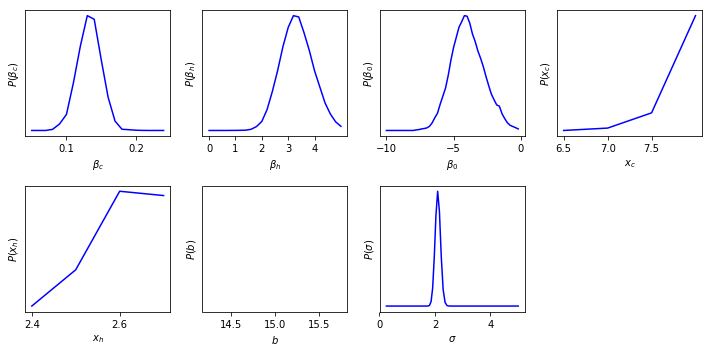

In [57]:
plt.figure( figsize=(10,5))

plt.subplot(2,4,1)
plt.plot(beta_c_range, post_beta_c,'b')
plt.xlabel(r'$\beta_c$')
plt.ylabel(r'$P(\beta_c)$')
plt.yticks([])

plt.subplot(2,4,2)
plt.plot(beta_h_range, post_beta_h,'b')
plt.xlabel(r'$\beta_h$')
plt.ylabel(r'$P(\beta_h)$')
plt.yticks([])
plt.xticks(np.arange(min(beta_h_range),max(beta_h_range),1))

plt.subplot(2,4,3)
plt.plot(beta_0_range, post_beta_0,'b')
plt.xlabel(r'$\beta_0$')
plt.ylabel(r'$P(\beta_0)$')
plt.yticks([])

plt.subplot(2,4,4)
plt.plot(xcs, post_xc,'b')
plt.xlabel(r'$x_c$')
plt.ylabel(r'$P(x_c)$')
plt.xticks(np.arange(min(xcs),max(xcs),0.5))
plt.yticks([])

plt.subplot(2,4,5)
plt.plot(xhs, post_xh,'b')
plt.xlabel(r'$x_h$')
plt.ylabel(r'$P(x_h)$')
plt.xticks(np.arange(min(xhs),2.7,0.2))
#plt.xlim(2.0,2.7)
plt.yticks([])

plt.subplot(2,4,6)
plt.plot(bs, post_b,'b')
#plt.plot(bs, np.histogram(sampled_b,bins=18,range=(3,20))[0],'r')
plt.xlabel(r'$b$')
plt.ylabel(r'$P(b)$')
#plt.xticks(np.arange(min(bs),max(bs),4))
#plt.xlim(3.0,20)
plt.yticks([])

plt.subplot(2,4,7)
plt.plot(sigma_range, post_sigma,'b')
#plt.plot(sigma_range, np.histogram(sampled_sigma,bins=len(post_sigma),range=(0.25,5))[0],'r')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$P(\sigma)$')
plt.yticks([])

plt.tight_layout()

#plt.savefig('z_10000000_H_final-ln_final0_everything.pdf')

# 2D marginal distributions

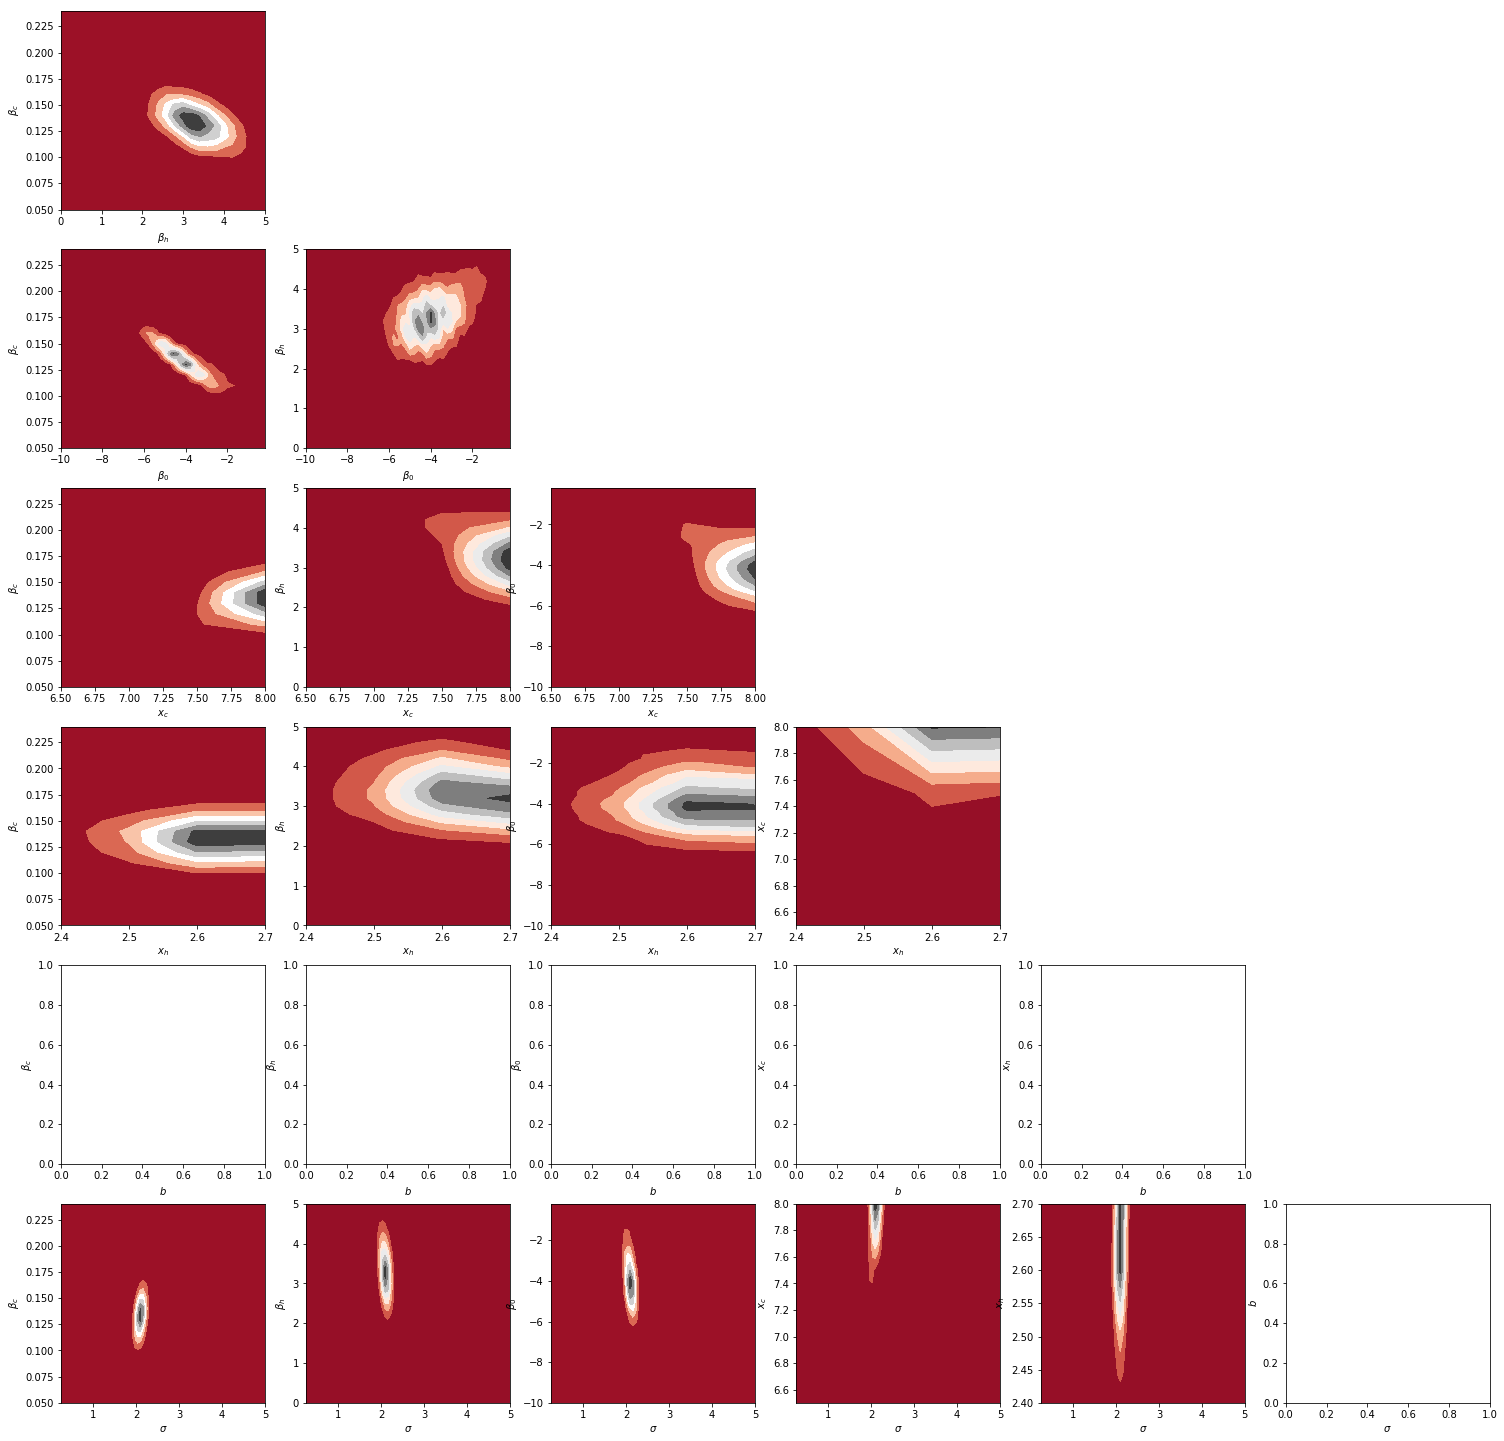

In [58]:
# 2D Marginal distributions

plt.figure( figsize=(30,30))

nparms = 7
parm_names = [r'$\beta_c$', r'$\beta_h$', r'$\beta_0$', r'$x_c$', r'$x_h$', r'$b$', r'$\sigma$'] 
parm_ranges =  [beta_c_range, beta_h_range, beta_0_range, xcs, xhs, bs, sigma_range]

for i in range(0,nparms-1):
    for j in range(i+1,nparms):
        
        # make an axis tuple that leaves out i and j
        axis_tuple = tuple([k for k in range(nparms) if ((k != i) and (k != j))])
        # print('axis_tuple', axis_tuple)
        
        this_panel = nparms*j + i + 1
        plt.subplot(nparms, nparms, this_panel)
        
        posterior_2D = sampled_states.sum( axis=axis_tuple ) 
        # print(posterior_2D.shape, len(parm_ranges[i]), len(parm_ranges[j]))
        
        X, Y = np.meshgrid(parm_ranges[j], parm_ranges[i])
        try:
            plt.contourf(X, Y, posterior_2D, cmap='RdGy')
            # plt.contour(X, Y, posterior_2D, cmap='RdGy')
        except:
            pass
        # plt.imshow(parm_ranges[i], parm_ranges[j], posterior_2D, 20, cmap='RdGy')
        plt.xlabel(parm_names[j])
        plt.ylabel(parm_names[i])
        
plt.show()
